# occupancy prediction

![img](dev/IMG_6435.jpg)

to do:
- prepare combinations of `timeunit` and `timestep` following the below trend

```python
{
    # timeunit : timestep
    10ms : 1500µs,
    7ms  : 1000µs,
    4ms  : 500µs,
    1ms  : 150µs
}
```
- simulated occupancy must not exceed real occupancy

<br>
<br>

In [18]:
# seaborn with custom background
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',rc={'figure.facecolor':'#abb2bf'})

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
from tqdm import tqdm_notebook, tnrange, trange, tqdm
from itertools import cycle
from collections import Counter
from pathlib import Path
import time
from contextlib import suppress

import altair as alt
from altair.expr import datum
alt.data_transformers.enable('json')

from _modules.wifi_traffic_analyzer import WifiTrafficAnalyzer

## params

In [2]:
timestep = 250
timeunit = 10_000

## configs

In [3]:
real_data_path_dict = {
    'real_2': Path(r'data/wifitrafficstats2.csv'),
    'real_3': Path(r'data/wifitrafficstats3.csv'),
    'real_4': Path(r'data/wifitrafficstats4.csv'),
    'real_5': Path(r'data/wifitrafficstats5.csv'),
    'real_6': Path(r'data/wifitrafficstats6.csv')
}

transition_matrices_path_dict = {
    'tmat_1': Path(r'data/wifi_t_matrices.csv'),
    #'tmat_2': Path(r'data/wifi_t_matrices2.csv')
}

## occupancy predictor

### classing it up

In [4]:
class OccupancyPredictor:
    def __init__(self, real_data_path_dict, timeunits, timesteps, autoselect_file=True):
        print('initializing OP..')
        
        # attributes
        self.real_data_path_dict = real_data_path_dict
        
        # set timeunits
        if not isinstance(timeunits, list):
            self.timeunits = [timeunits]
            print(f'\tsingle timeunit received {self.timeunits}')
        else:
            self.timeunits = timeunits
            print(f'\t{len(self.timeunits)} timeunits received')
            
        # set timesteps
        if not isinstance(timesteps, list):
            self.timesteps = [timesteps]
            print(f'\tsingle timestep received {self.timesteps}')
        else:
            if len(self.timeunits) > 1:
                print('ERROR: timeunit already list, timestep must be single value')
                raise ValueError
            self.timesteps = timesteps
            print(f'\t{len(self.timesteps)} timesteps received')
        
        # startup tasks
        self.WTA_real = WifiTrafficAnalyzer(mode='real', path_dict=self.real_data_path_dict)
        self.select_file_key(autoselect=autoselect_file)
        
        
    
    def select_file_key(self, autoselect):        
        if autoselect:
            self.file_key = list(self.WTA_real.path_dict.keys())[1]
            self.WTA_real.process_real_data(self.file_key)
            print(f'\tautoselected and processed \'{self.file_key}\'')
            
        else:
            file_key = input('please select a target file..')
            
            try:
                assert file_key.strip().lower() in self.WTA_real.path_dict.keys()
                
                self.file_key = file_key.strip().lower()
                self.WTA_real.process_real_data(self.file_key)
                
                print(f'\tset and processed target file: {self.file_key}')
                
            except AssertionError:
                print(f'invalid target file: {file_key}, options are {self.WTA_real.path_dict.keys()}')
                raise
        
        
    def convert_and_reshape(self, timeunit, downsample_factor):
        self.data_array = self.decimate_signal(
            self.WTA_real.real_data_array,
            downsample_factor
        )
        print(f'generated real data array, size: {self.data_array.shape}')
        
        data_matrix = (
            self.data_array[
                :int(timeunit*np.floor(len(self.data_array) / timeunit))
            ].reshape((-1, timeunit))
        )
        print(f'reshaped into {data_matrix.shape[0]} : {timeunit}µs chunks')
        
        return data_matrix
    
    
    def decimate_signal(self, data_array, factor):
        print(f'!!DEBUG!! decimate factor: {factor}')
        with suppress(FutureWarning):
            return signal.decimate(
                tuple(data_array),
                int(factor),
                ftype='fir'
            )
    
        
    def compute_transition_matrix(self, row, timeunit):
        onon, onoff, offon, offoff = 0, 0, 0, 0
        
        for i in range(timeunit-1):    
            # if ON -> ON
            if row[i] == row[i+1] == 1:
                onon += 1
                
            # if ON -> OFF
            elif row[i] == 1 and row[i+1] == 0:
                onoff += 1
                
            # if OFF -> ON
            elif row[i] == 0 and row[i+1] == 1:
                offon += 1
                
            #if OFF -> OFF
            elif row[i] == row[i+1] == 0:
                offoff += 1
                
        try:
            p_onon = onon / (onon + onoff)
        except ZeroDivisionError:
            p_onon = 0
        
        try:
            p_offoff = offoff / (offoff + offon)
        except ZeroDivisionError:
            p_offoff = 0
            
        try:
            p_onoff = onoff / (onon + onoff)
        except ZeroDivisionError:
            p_onoff = 0
            
        try:
            p_offon = offon / (offoff + offon)
        except ZeroDivisionError:
            p_offon = 0
            
        
        return (p_onon, p_onoff, p_offon, p_offoff) 
    
    
    def compute_tmats_and_load_df(self, data_matrix, timeunit):
        # compute all transition matrices
        tmat_array = [
            self.compute_transition_matrix(
                data_matrix[idx,:],
                timeunit
            )
            for idx in range(data_matrix.shape[0])
        ]
        
        # load dataframe
        tmat_df = (
            pd
            .DataFrame(
                tmat_array, 
                columns=['OnOn', 'OnOff', 'OffOn', 'OffOff']
            ).assign(
                timeunit = timeunit,
                source = self.file_key
            )
            [['OnOn','OnOff','OffOff','OffOn','timeunit','source']]
        )
        print(f'created transition matrix dataframe, {tmat_df.shape[0]} rows')
        
        return tmat_df
    
    
    def process_timeunit(self, timeunit, timestep):
        print(f'processing data for timeunit: {timeunit}µs')
        
        data_matrix = self.convert_and_reshape(timeunit, timestep)        
        tmat_df = self.compute_tmats_and_load_df(data_matrix, timeunit)
        
        return data_matrix, tmat_df
    
        
    def iterate_timeunits(self):
        df_dict = {}
        timestep = self.timesteps[0]
        print(f'iterating timeunits, using fixed timestep: {timestep}')
        
        for timeunit in tqdm_notebook(self.timeunits): 
            print('\n' + '='*50)
            print(f'processing timeunit {timeunit}')
            data_matrix, tmat_df = self.process_timeunit(int(timeunit/timestep), timestep) 
            print(f'data matrix: {data_matrix.shape}')
        
            sim_data_matrix = self.WTA_real.simulate_all_OP_transition_matrices(
                tmat_dataframe=tmat_df,
                n_samples=int(timeunit/timestep), 
                m_trials=1
            )[1:,:]
            
            print(f'sim data matrix: {sim_data_matrix.shape}')
            
            comp_df = (
                pd
                .DataFrame({
                    'real_data': data_matrix.sum(axis=1),
                    'sim_data': sim_data_matrix.sum(axis=1)
                })
                .assign(
                    real_data = lambda x: x.real_data.astype('int'),
                    sim_data = lambda x: x.sim_data.astype('int'),
                    timestep = timestep,
                    timeunit = timeunit
                )
                .eval('Diff = sim_data - real_data')
            )
            
            df_dict[timeunit] = comp_df            
        
        self.full_comp_df = pd.concat([df for df in df_dict.values()])
        self.iter_var = 'timeunit'
    
    
    def iterate_timesteps(self):
        df_dict = {}
        timeunit = self.timeunits[0]
        print(f'iterating timesteps, using fixed timeunit: {timeunit}')
        
        for timestep in tqdm_notebook(self.timesteps): 
            print('\n' + '='*50)
            print(f'processing timestep {timestep}')
            data_matrix, tmat_df = self.process_timeunit(int(timeunit/timestep), timestep) 
            print(f'data matrix: {data_matrix.shape}')
        
            sim_data_matrix = self.WTA_real.simulate_all_OP_transition_matrices(
                tmat_dataframe=tmat_df,
                n_samples=int(timeunit/timestep), 
                m_trials=1
            )[1:,:]
            
            print(f'sim data matrix: {sim_data_matrix.shape}')
            
            comp_df = (
                pd
                .DataFrame({
                    'real_data': data_matrix.sum(axis=1),
                    'sim_data': sim_data_matrix.sum(axis=1)
                })
                .assign(
                    real_data = lambda x: x.real_data.astype('int'),
                    sim_data = lambda x: x.sim_data.astype('int'),
                    timestep = timestep,
                    timeunit = timeunit,
                    Diff = lambda x: np.abs(x.sim_data - x.real_data)
                )
            )
            
            df_dict[timestep] = comp_df            
        
        self.full_comp_df = pd.concat([df for df in df_dict.values()])
        self.iter_var = 'timestep'
        
        
    def post_process_dataframe(self):
        self.comp_stats_df = (
            self
            .full_comp_df
            .eval('real_data = real_data * timestep / timeunit')
            .eval('sim_data = sim_data * timestep / timeunit')
            .assign(pct_diff = lambda x: np.abs(x.sim_data - x.real_data))
        )
        
        print(f'mean difference by {self.iter_var}:')
        display(
            self
            .comp_stats_df
            .groupby(self.iter_var)
            .Diff
            .mean()
            .rename('mean_diff')
            .to_frame()
        )

        

    def plot_mean_differences(self, background='#abb2bf'):
        # save data to disk
        self.comp_stats_df.to_csv('data/comp_stats_for_chart.csv', index=False)
        
        # set data ref
        alt_url = 'data/comp_stats_for_chart.csv'
                
        print('mean difference:')
        display(
            alt.Chart(
                alt_url
            ).mark_circle(
            ).encode(
                alt.X(f'{self.iter_var}:N'),
                alt.Y('mean(Diff):Q')
            ).properties(
                title=f'mean difference by {self.iter_var}'
            ).configure(
                background=background
            )
        )
        
        print('mean percent difference:')
        display(
            alt.Chart(
                alt_url
            ).mark_circle(
            ).encode(
                alt.X(f'{self.iter_var}:N'),
                alt.Y('mean(pct_diff):Q')
            ).properties(
                title=f'mean percent difference by {self.iter_var}'
            ).configure(
                background=background
            )
        )
    
    
        

## dev

### `timeunit` and `timestep` combination dev

#### setup

In [5]:
# provided sample points
base_ratios = [
    # timeunit, timestep
    (10, 1300),
    (9.5, 1200),
    (9, 1050),
    (7, 1000),
    (4, 500),
    (1, 150)
]

ratio_df = (
    pd
    .DataFrame(
        base_ratios, 
        columns=['timeunit','timestep']
    )
    .eval('ratio = timestep / timeunit')
)

extrapolated_list = [
    (i, ratio_df.ratio.mean() * i + 180) 
    for i in np.arange(0.5, 10.5, 0.5)
]

extrap_df = (
    pd
    .DataFrame(
        extrapolated_list, 
        columns=['timeunit','timestep']
    )
    #.eval('ratio = timestep / timeunit')
    .assign(timestep = lambda x: x.timestep.round(-1))
)

#### execution

In [7]:
full_comp_dict = {}
stats_dict = {}

for row in tqdm_notebook(extrap_df.itertuples(), total=extrap_df.shape[0]):
    timeunit = row.timeunit * 1000
    timestep_list = list(
        np.arange(
            row.timestep-0.2*row.timestep,
            row.timestep+0.2*row.timestep,
            0.05*row.timestep
        )
    )
    
    print(f'processing timeunit: {timeunit} for timesteps: {timestep_list}')
    
    OP = OccupancyPredictor(
        real_data_path_dict, 
        timeunits=timeunit, 
        timesteps=timestep_list, 
        autoselect_file=True
    )
    
    OP.iterate_timesteps()
    OP.post_process_dataframe()
    
    full_comp_dict[row.timeunit] = OP.full_comp_df
    stats_dict[row.timeunit] = OP.comp_stats_df

processing timeunit: 500.0 for timesteps: [200.0, 212.5, 225.0, 237.5, 250.0, 262.5, 275.0, 287.5]
initializing OP..
	single timeunit received [500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 500.0



processing timestep 200.0
processing data for timeunit: 2µs
!!DEBUG!! decimate factor: 200.0
generated real data array, size: (359425,)
reshaped into 179712 : 2µs chunks
created transition matrix dataframe, 179712 rows
data matrix: (179712, 2)
total elapsed time: 0.04 minutes
sim data matrix: (179712, 2)

processing timestep 212.5
processing data for timeunit: 2µs
!!DEBUG!! decimate factor: 212.5
generated real data array, size: (339080,)
reshaped into 169540 : 2µs chunks
created transition matrix dataframe, 169540 rows
data matrix: (169540, 2)
total elapsed time: 0.04 minutes
sim data matrix: (169540, 2)

processing timestep 225.0
processing data for timeunit: 2µs
!!DEBUG!! decimate factor: 225.0
generated real data array, size: (319489,)
reshaped into 159744 : 2µs chunks
created transition matrix dataframe, 159744 rows
data matrix: (159744, 2)
total elapsed time: 0.04 minutes
sim data matrix: (159744, 2)

processing timestep 237.5
processing data for timeunit: 2µs
!!DEBUG!! decimate

,mean_diff
timestep,
200.0,0.536625
212.5,0.532004
225.0,0.530968
237.5,0.529910
250.0,0.527551
262.5,0.282545
275.0,0.282839
287.5,0.283769


processing timeunit: 1000.0 for timesteps: [248.0, 263.5, 279.0, 294.5, 310.0, 325.5, 341.0, 356.5]
initializing OP..
	single timeunit received [1000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 1000.0



processing timestep 248.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 248.0
generated real data array, size: (289859,)
reshaped into 72464 : 4µs chunks
created transition matrix dataframe, 72464 rows
data matrix: (72464, 4)
total elapsed time: 0.03 minutes
sim data matrix: (72464, 4)

processing timestep 263.5
processing data for timeunit: 3µs
!!DEBUG!! decimate factor: 263.5
generated real data array, size: (273327,)
reshaped into 91109 : 3µs chunks
created transition matrix dataframe, 91109 rows
data matrix: (91109, 3)
total elapsed time: 0.03 minutes
sim data matrix: (91109, 3)

processing timestep 279.0
processing data for timeunit: 3µs
!!DEBUG!! decimate factor: 279.0
generated real data array, size: (257652,)
reshaped into 85884 : 3µs chunks
created transition matrix dataframe, 85884 rows
data matrix: (85884, 3)
total elapsed time: 0.03 minutes
sim data matrix: (85884, 3)

processing timestep 294.5
processing data for timeunit: 3µs
!!DEBUG!! decimate factor: 294

,mean_diff
timestep,
248.0,0.960187
263.5,0.746644
279.0,0.742816
294.5,0.737847
310.0,0.738819
325.5,0.735324
341.0,0.521465
356.5,0.516709


processing timeunit: 1500.0 for timesteps: [304.0, 323.0, 342.0, 361.0, 380.0, 399.0, 418.0, 437.0]
initializing OP..
	single timeunit received [1500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 1500.0



processing timestep 304.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 304.0
generated real data array, size: (236464,)
reshaped into 59116 : 4µs chunks
created transition matrix dataframe, 59116 rows
data matrix: (59116, 4)
total elapsed time: 0.02 minutes
sim data matrix: (59116, 4)

processing timestep 323.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 323.0
generated real data array, size: (222554,)
reshaped into 55638 : 4µs chunks
created transition matrix dataframe, 55638 rows
data matrix: (55638, 4)
total elapsed time: 0.02 minutes
sim data matrix: (55638, 4)

processing timestep 342.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 342.0
generated real data array, size: (210190,)
reshaped into 52547 : 4µs chunks
created transition matrix dataframe, 52547 rows
data matrix: (52547, 4)
total elapsed time: 0.02 minutes
sim data matrix: (52547, 4)

processing timestep 361.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 361

,mean_diff
timestep,
304.0,0.939593
323.0,0.939717
342.0,0.941709
361.0,0.934976
380.0,0.731703
399.0,0.728378
418.0,0.728438
437.0,0.727896


processing timeunit: 2000.0 for timesteps: [352.0, 374.0, 396.0, 418.0, 440.0, 462.0, 484.0, 506.0]
initializing OP..
	single timeunit received [2000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 2000.0



processing timestep 352.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 352.0
generated real data array, size: (204219,)
reshaped into 40843 : 5µs chunks
created transition matrix dataframe, 40843 rows
data matrix: (40843, 5)
total elapsed time: 0.02 minutes
sim data matrix: (40843, 5)

processing timestep 374.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 374.0
generated real data array, size: (192206,)
reshaped into 38441 : 5µs chunks
created transition matrix dataframe, 38441 rows
data matrix: (38441, 5)
total elapsed time: 0.02 minutes
sim data matrix: (38441, 5)

processing timestep 396.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 396.0
generated real data array, size: (181528,)
reshaped into 36305 : 5µs chunks
created transition matrix dataframe, 36305 rows
data matrix: (36305, 5)
total elapsed time: 0.01 minutes
sim data matrix: (36305, 5)

processing timestep 418.0
processing data for timeunit: 4µs
!!DEBUG!! decimate factor: 418

,mean_diff
timestep,
352.0,1.137453
374.0,1.131110
396.0,1.129596
418.0,0.931780
440.0,0.926132
462.0,0.922414
484.0,0.912416
506.0,0.720452


processing timeunit: 2500.0 for timesteps: [408.0, 433.5, 459.0, 484.5, 510.0, 535.5, 561.0, 586.5]
initializing OP..
	single timeunit received [2500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 2500.0



processing timestep 408.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 408.0
generated real data array, size: (176189,)
reshaped into 29364 : 6µs chunks
created transition matrix dataframe, 29364 rows
data matrix: (29364, 6)
total elapsed time: 0.01 minutes
sim data matrix: (29364, 6)

processing timestep 433.5
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 433.5
generated real data array, size: (166016,)
reshaped into 33203 : 5µs chunks
created transition matrix dataframe, 33203 rows
data matrix: (33203, 5)
total elapsed time: 0.01 minutes
sim data matrix: (33203, 5)

processing timestep 459.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 459.0
generated real data array, size: (156612,)
reshaped into 31322 : 5µs chunks
created transition matrix dataframe, 31322 rows
data matrix: (31322, 5)
total elapsed time: 0.01 minutes
sim data matrix: (31322, 5)

processing timestep 484.5
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 484

,mean_diff
timestep,
408.0,1.314296
433.5,1.129386
459.0,1.105677
484.5,1.107797
510.0,0.927690
535.5,0.906552
561.0,0.901636
586.5,0.898262


processing timeunit: 3000.0 for timesteps: [464.0, 493.0, 522.0, 551.0, 580.0, 609.0, 638.0, 667.0]
initializing OP..
	single timeunit received [3000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 3000.0



processing timestep 464.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 464.0
generated real data array, size: (154925,)
reshaped into 25820 : 6µs chunks
created transition matrix dataframe, 25820 rows
data matrix: (25820, 6)
total elapsed time: 0.01 minutes
sim data matrix: (25820, 6)

processing timestep 493.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 493.0
generated real data array, size: (145812,)
reshaped into 24302 : 6µs chunks
created transition matrix dataframe, 24302 rows
data matrix: (24302, 6)
total elapsed time: 0.01 minutes
sim data matrix: (24302, 6)

processing timestep 522.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 522.0
generated real data array, size: (137711,)
reshaped into 27542 : 5µs chunks
created transition matrix dataframe, 27542 rows
data matrix: (27542, 5)
total elapsed time: 0.01 minutes
sim data matrix: (27542, 5)

processing timestep 551.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 551

,mean_diff
timestep,
464.0,1.297947
493.0,1.288989
522.0,1.115061
551.0,1.097539
580.0,1.096821
609.0,0.909587
638.0,0.904857
667.0,0.896782


processing timeunit: 3500.0 for timesteps: [512.0, 544.0, 576.0, 608.0, 640.0, 672.0, 704.0, 736.0]
initializing OP..
	single timeunit received [3500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 3500.0



processing timestep 512.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 512.0
generated real data array, size: (140401,)
reshaped into 23400 : 6µs chunks
created transition matrix dataframe, 23400 rows
data matrix: (23400, 6)
total elapsed time: 0.01 minutes
sim data matrix: (23400, 6)

processing timestep 544.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 544.0
generated real data array, size: (132142,)
reshaped into 22023 : 6µs chunks
created transition matrix dataframe, 22023 rows
data matrix: (22023, 6)
total elapsed time: 0.01 minutes
sim data matrix: (22023, 6)

processing timestep 576.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 576.0
generated real data array, size: (124801,)
reshaped into 20800 : 6µs chunks
created transition matrix dataframe, 20800 rows
data matrix: (20800, 6)
total elapsed time: 0.01 minutes
sim data matrix: (20800, 6)

processing timestep 608.0
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 608

,mean_diff
timestep,
512.0,1.300043
544.0,1.301639
576.0,1.278462
608.0,1.085088
640.0,1.080840
672.0,1.089558
704.0,0.905081
736.0,0.898022


processing timeunit: 4000.0 for timesteps: [568.0, 603.5, 639.0, 674.5, 710.0, 745.5, 781.0, 816.5]
initializing OP..
	single timeunit received [4000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 4000.0



processing timestep 568.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 568.0
generated real data array, size: (126558,)
reshaped into 18079 : 7µs chunks
created transition matrix dataframe, 18079 rows
data matrix: (18079, 7)
total elapsed time: 0.01 minutes
sim data matrix: (18079, 7)

processing timestep 603.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 603.5
generated real data array, size: (119213,)
reshaped into 19868 : 6µs chunks
created transition matrix dataframe, 19868 rows
data matrix: (19868, 6)
total elapsed time: 0.01 minutes
sim data matrix: (19868, 6)

processing timestep 639.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 639.0
generated real data array, size: (112496,)
reshaped into 18749 : 6µs chunks
created transition matrix dataframe, 18749 rows
data matrix: (18749, 6)
total elapsed time: 0.01 minutes
sim data matrix: (18749, 6)

processing timestep 674.5
processing data for timeunit: 5µs
!!DEBUG!! decimate factor: 674

,mean_diff
timestep,
568.0,1.480392
603.5,1.276475
639.0,1.260387
674.5,1.079696
710.0,1.079609
745.5,1.081874
781.0,1.065624
816.5,0.887436


processing timeunit: 4500.0 for timesteps: [616.0, 654.5, 693.0, 731.5, 770.0, 808.5, 847.0, 885.5]
initializing OP..
	single timeunit received [4500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 4500.0



processing timestep 616.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 616.0
generated real data array, size: (116697,)
reshaped into 16671 : 7µs chunks
created transition matrix dataframe, 16671 rows
data matrix: (16671, 7)
total elapsed time: 0.01 minutes
sim data matrix: (16671, 7)

processing timestep 654.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 654.5
generated real data array, size: (109916,)
reshaped into 18319 : 6µs chunks
created transition matrix dataframe, 18319 rows
data matrix: (18319, 6)
total elapsed time: 0.01 minutes
sim data matrix: (18319, 6)

processing timestep 693.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 693.0
generated real data array, size: (103731,)
reshaped into 17288 : 6µs chunks
created transition matrix dataframe, 17288 rows
data matrix: (17288, 6)
total elapsed time: 0.01 minutes
sim data matrix: (17288, 6)

processing timestep 731.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 731

,mean_diff
timestep,
616.0,1.461160
654.5,1.275506
693.0,1.271576
731.5,1.268778
770.0,1.071180
808.5,1.066431
847.0,1.068693
885.5,1.071345


processing timeunit: 5000.0 for timesteps: [672.0, 714.0, 756.0, 798.0, 840.0, 882.0, 924.0, 966.0]
initializing OP..
	single timeunit received [5000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 5000.0



processing timestep 672.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 672.0
generated real data array, size: (106972,)
reshaped into 15281 : 7µs chunks
created transition matrix dataframe, 15281 rows
data matrix: (15281, 7)
total elapsed time: 0.01 minutes
sim data matrix: (15281, 7)

processing timestep 714.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 714.0
generated real data array, size: (100680,)
reshaped into 14382 : 7µs chunks
created transition matrix dataframe, 14382 rows
data matrix: (14382, 7)
total elapsed time: 0.01 minutes
sim data matrix: (14382, 7)

processing timestep 756.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 756.0
generated real data array, size: (95086,)
reshaped into 15847 : 6µs chunks
created transition matrix dataframe, 15847 rows
data matrix: (15847, 6)
total elapsed time: 0.01 minutes
sim data matrix: (15847, 6)

processing timestep 798.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 798.

,mean_diff
timestep,
672.0,1.465022
714.0,1.452719
756.0,1.276014
798.0,1.244988
840.0,1.051242
882.0,1.067914
924.0,1.072884
966.0,1.069072


processing timeunit: 5500.0 for timesteps: [720.0, 765.0, 810.0, 855.0, 900.0, 945.0, 990.0, 1035.0]
initializing OP..
	single timeunit received [5500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 5500.0



processing timestep 720.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 720.0
generated real data array, size: (99841,)
reshaped into 14263 : 7µs chunks
created transition matrix dataframe, 14263 rows
data matrix: (14263, 7)
total elapsed time: 0.01 minutes
sim data matrix: (14263, 7)

processing timestep 765.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 765.0
generated real data array, size: (93968,)
reshaped into 13424 : 7µs chunks
created transition matrix dataframe, 13424 rows
data matrix: (13424, 7)
total elapsed time: 0.01 minutes
sim data matrix: (13424, 7)

processing timestep 810.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 810.0
generated real data array, size: (88747,)
reshaped into 14791 : 6µs chunks
created transition matrix dataframe, 14791 rows
data matrix: (14791, 6)
total elapsed time: 0.01 minutes
sim data matrix: (14791, 6)

processing timestep 855.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 855.0


,mean_diff
timestep,
720.0,1.462666
765.0,1.459923
810.0,1.256507
855.0,1.246788
900.0,1.250901
945.0,1.056005
990.0,1.063972
1035.0,1.045857


processing timeunit: 6000.0 for timesteps: [776.0, 824.5, 873.0, 921.5, 970.0, 1018.5, 1067.0, 1115.5]
initializing OP..
	single timeunit received [6000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 6000.0



processing timestep 776.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 776.0
generated real data array, size: (92636,)
reshaped into 13233 : 7µs chunks
created transition matrix dataframe, 13233 rows
data matrix: (13233, 7)
total elapsed time: 0.01 minutes
sim data matrix: (13233, 7)

processing timestep 824.5
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 824.5
generated real data array, size: (87239,)
reshaped into 12462 : 7µs chunks
created transition matrix dataframe, 12462 rows
data matrix: (12462, 7)
total elapsed time: 0.01 minutes
sim data matrix: (12462, 7)

processing timestep 873.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 873.0
generated real data array, size: (82343,)
reshaped into 13723 : 6µs chunks
created transition matrix dataframe, 13723 rows
data matrix: (13723, 6)
total elapsed time: 0.01 minutes
sim data matrix: (13723, 6)

processing timestep 921.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 921.5


,mean_diff
timestep,
776.0,1.432479
824.5,1.437169
873.0,1.235298
921.5,1.237162
970.0,1.222330
1018.5,1.048435
1067.0,1.050690
1115.5,1.044362


processing timeunit: 6500.0 for timesteps: [832.0, 884.0, 936.0, 988.0, 1040.0, 1092.0, 1144.0, 1196.0]
initializing OP..
	single timeunit received [6500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 6500.0



processing timestep 832.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 832.0
generated real data array, size: (86401,)
reshaped into 12343 : 7µs chunks
created transition matrix dataframe, 12343 rows
data matrix: (12343, 7)
total elapsed time: 0.01 minutes
sim data matrix: (12343, 7)

processing timestep 884.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 884.0
generated real data array, size: (81318,)
reshaped into 11616 : 7µs chunks
created transition matrix dataframe, 11616 rows
data matrix: (11616, 7)
total elapsed time: 0.01 minutes
sim data matrix: (11616, 7)

processing timestep 936.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 936.0
generated real data array, size: (76801,)
reshaped into 12800 : 6µs chunks
created transition matrix dataframe, 12800 rows
data matrix: (12800, 6)
total elapsed time: 0.01 minutes
sim data matrix: (12800, 6)

processing timestep 988.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 988.0


,mean_diff
timestep,
832.0,1.438305
884.0,1.438619
936.0,1.238594
988.0,1.248144
1040.0,1.234462
1092.0,1.040106
1144.0,1.035490
1196.0,1.032443


processing timeunit: 7000.0 for timesteps: [880.0, 935.0, 990.0, 1045.0, 1100.0, 1155.0, 1210.0, 1265.0]
initializing OP..
	single timeunit received [7000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 7000.0



processing timestep 880.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 880.0
generated real data array, size: (81688,)
reshaped into 11669 : 7µs chunks
created transition matrix dataframe, 11669 rows
data matrix: (11669, 7)
total elapsed time: 0.01 minutes
sim data matrix: (11669, 7)

processing timestep 935.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 935.0
generated real data array, size: (76883,)
reshaped into 10983 : 7µs chunks
created transition matrix dataframe, 10983 rows
data matrix: (10983, 7)
total elapsed time: 0.01 minutes
sim data matrix: (10983, 7)

processing timestep 990.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 990.0
generated real data array, size: (72612,)
reshaped into 10373 : 7µs chunks
created transition matrix dataframe, 10373 rows
data matrix: (10373, 7)
total elapsed time: 0.01 minutes
sim data matrix: (10373, 7)

processing timestep 1045.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1045.

,mean_diff
timestep,
880.0,1.438598
935.0,1.420013
990.0,1.429288
1045.0,1.236895
1100.0,1.213754
1155.0,1.217295
1210.0,1.032907
1265.0,1.020502


processing timeunit: 7500.0 for timesteps: [936.0, 994.5, 1053.0, 1111.5, 1170.0, 1228.5, 1287.0, 1345.5]
initializing OP..
	single timeunit received [7500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 7500.0



processing timestep 936.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 936.0
generated real data array, size: (76801,)
reshaped into 9600 : 8µs chunks
created transition matrix dataframe, 9600 rows
data matrix: (9600, 8)
total elapsed time: 0.01 minutes
sim data matrix: (9600, 8)

processing timestep 994.5
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 994.5
generated real data array, size: (72319,)
reshaped into 10331 : 7µs chunks
created transition matrix dataframe, 10331 rows
data matrix: (10331, 7)
total elapsed time: 0.01 minutes
sim data matrix: (10331, 7)

processing timestep 1053.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1053.0
generated real data array, size: (68267,)
reshaped into 9752 : 7µs chunks
created transition matrix dataframe, 9752 rows
data matrix: (9752, 7)
total elapsed time: 0.00 minutes
sim data matrix: (9752, 7)

processing timestep 1111.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1111.5
gene

,mean_diff
timestep,
936.0,1.620521
994.5,1.423289
1053.0,1.421760
1111.5,1.226189
1170.0,1.215332
1228.5,1.187679
1287.0,1.023454
1345.5,1.020863


processing timeunit: 8000.0 for timesteps: [984.0, 1045.5, 1107.0, 1168.5, 1230.0, 1291.5, 1353.0, 1414.5]
initializing OP..
	single timeunit received [8000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 8000.0



processing timestep 984.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 984.0
generated real data array, size: (73054,)
reshaped into 9131 : 8µs chunks
created transition matrix dataframe, 9131 rows
data matrix: (9131, 8)
total elapsed time: 0.00 minutes
sim data matrix: (9131, 8)

processing timestep 1045.5
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1045.5
generated real data array, size: (68790,)
reshaped into 9827 : 7µs chunks
created transition matrix dataframe, 9827 rows
data matrix: (9827, 7)
total elapsed time: 0.00 minutes
sim data matrix: (9827, 7)

processing timestep 1107.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1107.0
generated real data array, size: (64937,)
reshaped into 9276 : 7µs chunks
created transition matrix dataframe, 9276 rows
data matrix: (9276, 7)
total elapsed time: 0.00 minutes
sim data matrix: (9276, 7)

processing timestep 1168.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1168.5
genera

,mean_diff
timestep,
984.0,1.610667
1045.5,1.411418
1107.0,1.421410
1168.5,1.205811
1230.0,1.206468
1291.5,1.191595
1353.0,1.011293
1414.5,1.010328


processing timeunit: 8500.0 for timesteps: [1040.0, 1105.0, 1170.0, 1235.0, 1300.0, 1365.0, 1430.0, 1495.0]
initializing OP..
	single timeunit received [8500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 8500.0



processing timestep 1040.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 1040.0
generated real data array, size: (69121,)
reshaped into 8640 : 8µs chunks
created transition matrix dataframe, 8640 rows
data matrix: (8640, 8)
total elapsed time: 0.00 minutes
sim data matrix: (8640, 8)

processing timestep 1105.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1105.0
generated real data array, size: (65055,)
reshaped into 9293 : 7µs chunks
created transition matrix dataframe, 9293 rows
data matrix: (9293, 7)
total elapsed time: 0.00 minutes
sim data matrix: (9293, 7)

processing timestep 1170.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1170.0
generated real data array, size: (61441,)
reshaped into 8777 : 7µs chunks
created transition matrix dataframe, 8777 rows
data matrix: (8777, 7)
total elapsed time: 0.00 minutes
sim data matrix: (8777, 7)

processing timestep 1235.0
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1235.0
gene

,mean_diff
timestep,
1040.0,1.605208
1105.0,1.388142
1170.0,1.401048
1235.0,1.199979
1300.0,1.208659
1365.0,1.206107
1430.0,1.004874
1495.0,1.008215


processing timeunit: 9000.0 for timesteps: [1096.0, 1164.5, 1233.0, 1301.5, 1370.0, 1438.5, 1507.0, 1575.5]
initializing OP..
	single timeunit received [9000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 9000.0



processing timestep 1096.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 1096.0
generated real data array, size: (65589,)
reshaped into 8198 : 8µs chunks
created transition matrix dataframe, 8198 rows
data matrix: (8198, 8)
total elapsed time: 0.00 minutes
sim data matrix: (8198, 8)

processing timestep 1164.5
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1164.5
generated real data array, size: (61757,)
reshaped into 8822 : 7µs chunks
created transition matrix dataframe, 8822 rows
data matrix: (8822, 7)
total elapsed time: 0.00 minutes
sim data matrix: (8822, 7)

processing timestep 1233.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1233.0
generated real data array, size: (58301,)
reshaped into 8328 : 7µs chunks
created transition matrix dataframe, 8328 rows
data matrix: (8328, 7)
total elapsed time: 0.00 minutes
sim data matrix: (8328, 7)

processing timestep 1301.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1301.5
gene

,mean_diff
timestep,
1096.0,1.597463
1164.5,1.399683
1233.0,1.382925
1301.5,1.185688
1370.0,1.200800
1438.5,1.187733
1507.0,1.003774
1575.5,0.995727


processing timeunit: 9500.0 for timesteps: [1144.0, 1215.5, 1287.0, 1358.5, 1430.0, 1501.5, 1573.0, 1644.5]
initializing OP..
	single timeunit received [9500.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 9500.0



processing timestep 1144.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 1144.0
generated real data array, size: (62837,)
reshaped into 7854 : 8µs chunks
created transition matrix dataframe, 7854 rows
data matrix: (7854, 8)
total elapsed time: 0.00 minutes
sim data matrix: (7854, 8)

processing timestep 1215.5
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1215.5
generated real data array, size: (59165,)
reshaped into 8452 : 7µs chunks
created transition matrix dataframe, 8452 rows
data matrix: (8452, 7)
total elapsed time: 0.00 minutes
sim data matrix: (8452, 7)

processing timestep 1287.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1287.0
generated real data array, size: (55855,)
reshaped into 7979 : 7µs chunks
created transition matrix dataframe, 7979 rows
data matrix: (7979, 7)
total elapsed time: 0.00 minutes
sim data matrix: (7979, 7)

processing timestep 1358.5
processing data for timeunit: 6µs
!!DEBUG!! decimate factor: 1358.5
gene

,mean_diff
timestep,
1144.0,1.578941
1215.5,1.391505
1287.0,1.383256
1358.5,1.176491
1430.0,1.193483
1501.5,1.204209
1573.0,1.195772
1644.5,1.006061


processing timeunit: 10000.0 for timesteps: [1200.0, 1275.0, 1350.0, 1425.0, 1500.0, 1575.0, 1650.0, 1725.0]
initializing OP..
	single timeunit received [10000.0]
	8 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data/wifitrafficstats2.csv
	key: real_3, path: data/wifitrafficstats3.csv
	key: real_4, path: data/wifitrafficstats4.csv
	key: real_5, path: data/wifitrafficstats5.csv
	key: real_6, path: data/wifitrafficstats6.csv
	autoselected and processed 'real_3'
iterating timesteps, using fixed timeunit: 10000.0



processing timestep 1200.0
processing data for timeunit: 8µs
!!DEBUG!! decimate factor: 1200.0
generated real data array, size: (59905,)
reshaped into 7488 : 8µs chunks
created transition matrix dataframe, 7488 rows
data matrix: (7488, 8)
total elapsed time: 0.00 minutes
sim data matrix: (7488, 8)

processing timestep 1275.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1275.0
generated real data array, size: (56381,)
reshaped into 8054 : 7µs chunks
created transition matrix dataframe, 8054 rows
data matrix: (8054, 7)
total elapsed time: 0.00 minutes
sim data matrix: (8054, 7)

processing timestep 1350.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1350.0
generated real data array, size: (53249,)
reshaped into 7607 : 7µs chunks
created transition matrix dataframe, 7607 rows
data matrix: (7607, 7)
total elapsed time: 0.00 minutes
sim data matrix: (7607, 7)

processing timestep 1425.0
processing data for timeunit: 7µs
!!DEBUG!! decimate factor: 1425.0
gene

,mean_diff
timestep,
1200.0,1.591747
1275.0,1.357710
1350.0,1.363218
1425.0,1.379961
1500.0,1.196194
1575.0,1.177600
1650.0,1.176697
1725.0,0.986201


In [8]:
zerina_project_data_dict = {
    'full_comp_dict': full_comp_dict,
    'stats_dict': stats_dict
}

%store zerina_project_data_dict

Stored 'zerina_project_data_dict' (dict)


### evaluation

#### postprocess

In [9]:
full_comp_df = (
    pd
    .concat([df for df in full_comp_dict.values()])
    .drop('Diff', axis=1)
    .eval('Diff = sim_data - real_data')
    [['real_data', 'sim_data', 'timeunit', 'timestep', 'Diff']]
)
print('discrete comparison:')
display(full_comp_df.head())

stats_df = (
    pd
    .concat([df for df in stats_dict.values()])
    .drop(['Diff','pct_diff'], axis=1)
    .eval('Diff = sim_data - real_data')
    .eval('real_data = real_data * timestep / timeunit')
    .eval('sim_data = sim_data * timestep / timeunit')
    .eval('pct_diff = sim_data - real_data')
)
#print('normalized comparison:')
#display(stats_df.head())

discrete comparison:


,real_data,sim_data,timeunit,timestep,Diff
0,1,0,500.0,200.0,-1
1,1,0,500.0,200.0,-1
2,1,0,500.0,200.0,-1
3,0,0,500.0,200.0,0
4,0,1,500.0,200.0,1


#### error compuation

*column breakdown*
- `Diff`
    - `sim_data` - `real_data`
- `error`
    - the number of positive `Diff` divided by the total number
- `pos_occ`
    - the sum of positive `Diff`
- `neg_occ`
    - the sum of negative or 0 `Diff`
- `occ_ratio`
    - the absolute value of `pos_occ` divided by `neg_occ`

In [17]:
error_df = (
    full_comp_df
    [['timeunit','timestep']]
    .drop_duplicates()
    .assign(
        error = [
            subframe.query('Diff > 0').shape[0] / subframe.shape[0]
            for _, subframe 
            in full_comp_df.groupby(['timeunit','timestep'])
        ],
        pos_occ = [
            subframe.query('Diff > 0').Diff.sum()
            for _, subframe 
            in full_comp_df.groupby(['timeunit','timestep'])
        ],
        neg_occ = [
            subframe.query('Diff <= 0').Diff.sum()
            for _, subframe 
            in full_comp_df.groupby(['timeunit','timestep'])
        ],
        occ_ratio = lambda x: [
            np.abs(pos / neg)
            for pos, neg 
            in zip(x.pos_occ, x.neg_occ)
        ]
    )
    .round(4)
)

error_df.head()

,timeunit,timestep,error,pos_occ,neg_occ,occ_ratio
0,500.0,200.0,0.2154,56150,-40288,1.3937
0,500.0,212.5,0.2137,52401,-37795,1.3865
0,500.0,225.0,0.2149,49583,-35236,1.4072
0,500.0,237.5,0.2130,46830,-33534,1.3965
0,500.0,250.0,0.2152,44780,-31066,1.4414


## visualization

### `timestep` vs [`pos_occ`, `neg_occ`], colored by `timeunit`

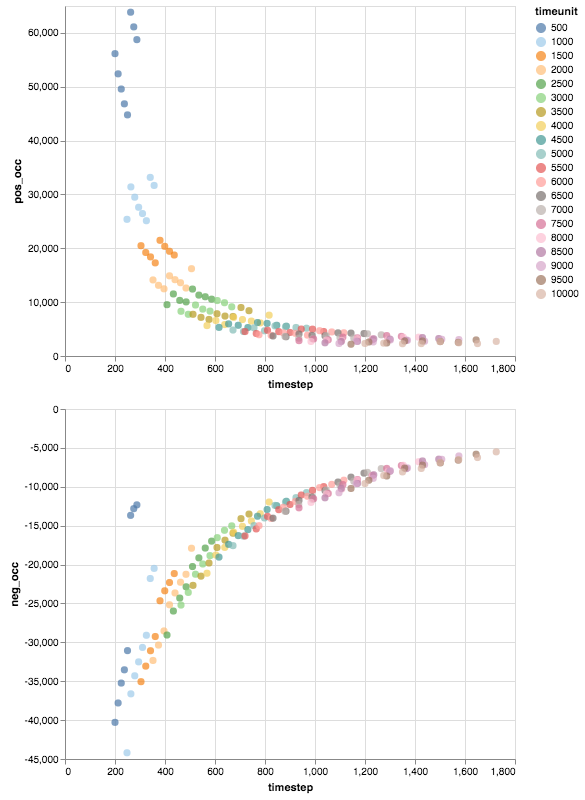

In [47]:
pos_scatter = alt.Chart(
    error_df,
    height=350,
    width=450
).mark_circle(
    size=50
).encode(
    alt.X('timestep:Q'),
    alt.Y('pos_occ:Q'),
    color=alt.Color(
        'timeunit:N',
        scale=alt.Scale(scheme='tableau20')
    ),
    tooltip=[
        alt.Tooltip('timeunit:N'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('error:Q'),
    ]
)

neg_scatter = alt.Chart(
    error_df,
    height=350,
    width=450
).mark_circle(
    size=50
).encode(
    alt.X('timestep:Q'),
    alt.Y('neg_occ:Q'),
    color=alt.Color(
        'timeunit:N',
        scale=alt.Scale(scheme='tableau20')
    ),
    tooltip=[
        alt.Tooltip('timeunit:N'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('error:Q'),
    ]
)

alt.vconcat(
    pos_scatter,
    neg_scatter,
    background='#ffffff'
)

### `timestep` vs `occ_ratio`, colored by `timeunit`

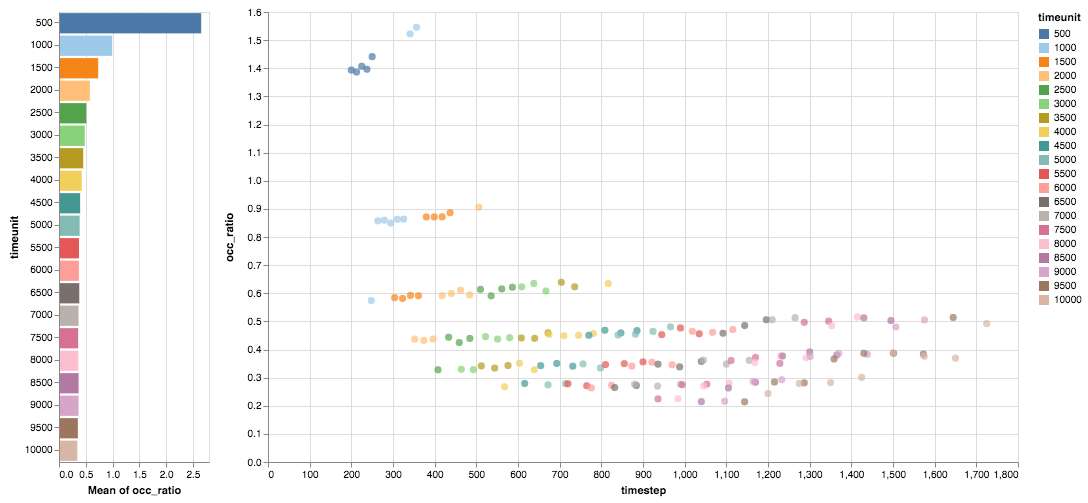

In [42]:
sel_timeunit = alt.selection_multi(encodings=['y'])

bar_chart = alt.Chart(
    error_df,
    height=450,
    width=150
).mark_bar(
).encode(
    alt.X('mean(occ_ratio):Q'),
    alt.Y('timeunit:N'),
    color = alt.condition(
        sel_timeunit,
        'timeunit:N',
        alt.value('#96989b'),
        scale=alt.Scale(scheme='tableau20'),
        legend=alt.Legend(title='timeunit')
    ),
).add_selection(
    sel_timeunit
)

scatter = alt.Chart(
    error_df.query('occ_ratio < 4.5'),
    #.query('timeunit > 500'),
    height=450,
    width=750
).mark_circle(
    size=50
).transform_filter(
    sel_timeunit
).encode(
    alt.X('timestep:Q'),
    alt.Y('occ_ratio:Q'),
    color=alt.Color(
        'timeunit:N',
        scale=alt.Scale(scheme='tableau20')
    ),
    tooltip=[
        alt.Tooltip('timeunit:N'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('error:Q'),
        alt.Tooltip('pos_occ:Q'),
        alt.Tooltip('neg_occ:Q'),
        alt.Tooltip('occ_ratio:Q'),
    ]
)

main_chart = alt.hconcat(
    bar_chart,
    scatter,
    background='#ffffff'
)

display(main_chart)

### timestep vs error, colored by timeunit

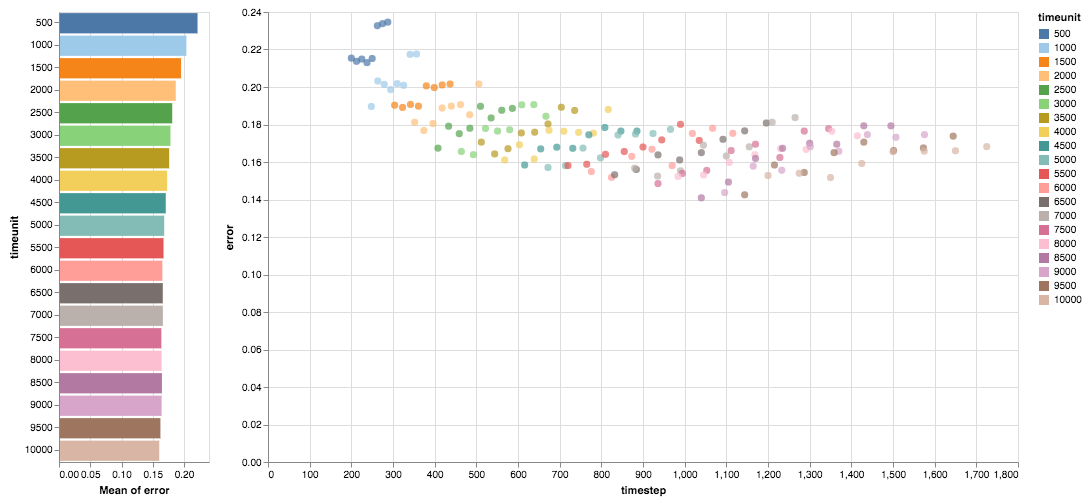

In [36]:
sel_timeunit = alt.selection_multi(encodings=['y'])

bar_chart = alt.Chart(
    error_df,
    height=450,
    width=150
).mark_bar(
).encode(
    alt.X('mean(error):Q'),
    alt.Y('timeunit:N'),
    color = alt.condition(
        sel_timeunit,
        'timeunit:N',
        alt.value('#96989b'),
        scale=alt.Scale(scheme='tableau20'),
        legend=alt.Legend(title='timeunit')
    ),
).add_selection(
    sel_timeunit
)

scatter = alt.Chart(
    error_df,
    height=450,
    width=750
).mark_circle(
    size=50
).transform_filter(
    sel_timeunit
).encode(
    alt.X('timestep:Q'),
    alt.Y('error:Q'),
    color=alt.Color(
        'timeunit:N',
        scale=alt.Scale(scheme='tableau20')
    ),
    tooltip=[
        alt.Tooltip('timeunit:N'),
        alt.Tooltip('timestep:N'),
        alt.Tooltip('error:Q'),
    ]
)

main_chart = alt.hconcat(
    bar_chart,
    scatter,
    background='#ffffff'
)

display(main_chart)

### weird chart

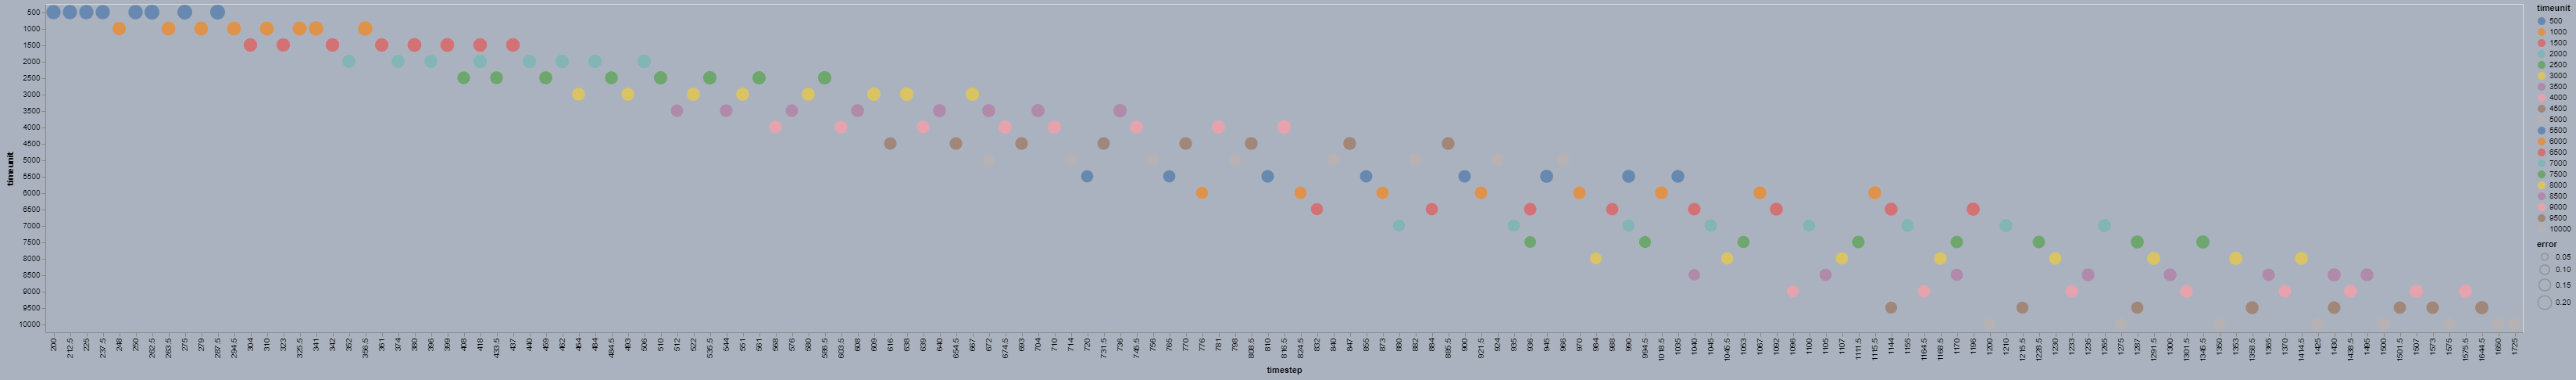

In [188]:
alt.Chart(
    error_df
).mark_circle(
).encode(
    alt.Y('timeunit:N'),
    alt.X('timestep:N'),
    color='timeunit:N',
    size='error:Q'
).configure(background='#abb2bf')

## OLD BELOW

### iterating timeunits

In [ ]:
OP = OccupancyPredictor(
    real_data_path_dict, 
    timeunits=list(range(9000, 11000, 50)), 
    timesteps=1000, 
    autoselect_file=True
)

In [ ]:
OP.iterate_timeunits()

In [ ]:
OP.post_process_dataframe()

In [ ]:
OP.plot_mean_differences()

### iterating timesteps

In [5]:
OP = OccupancyPredictor(
    real_data_path_dict, 
    timeunits=10_000, 
    timesteps=list(range(100, 1000, 100)), 
    autoselect_file=True
)

initializing OP..
	single timeunit received [10000]
	9 timesteps received
initializing WTA..
initialization complete, mode: real
real data options: 
	key: real_2, path: data\wifitrafficstats2.csv
	key: real_3, path: data\wifitrafficstats3.csv
	key: real_4, path: data\wifitrafficstats4.csv
	key: real_5, path: data\wifitrafficstats5.csv
	key: real_6, path: data\wifitrafficstats6.csv
	autoselected and processed 'real_3'


In [6]:
OP.iterate_timesteps()

iterating timesteps, using fixed timeunit: 10000



processing timestep 100
processing data for timeunit: 100µs
generated real data array, size: (718850,)
reshaped into 7188 : 100µs chunks
created transition matrix dataframe, 7188 rows
data matrix: (7188, 100)
total elapsed time: 0.03 minutes
sim data matrix: (7188, 100)

processing timestep 200
processing data for timeunit: 50µs
generated real data array, size: (359425,)
reshaped into 7188 : 50µs chunks
created transition matrix dataframe, 7188 rows
data matrix: (7188, 50)
total elapsed time: 0.02 minutes
sim data matrix: (7188, 50)

processing timestep 300
processing data for timeunit: 33µs
generated real data array, size: (239617,)
reshaped into 7261 : 33µs chunks
created transition matrix dataframe, 7261 rows
data matrix: (7261, 33)
total elapsed time: 0.01 minutes
sim data matrix: (7261, 33)

processing timestep 400
processing data for timeunit: 25µs
generated real data array, size: (179713,)
reshaped into 7188 : 25µs chunks
created transition matrix dataframe, 7188 rows
data matr

In [7]:
OP.post_process_dataframe()

mean difference by timestep:


,mean_diff
timestep,
100,22.898998
200,11.147885
300,7.188679
400,5.326099
500,4.187813
600,3.298210
700,2.840082
800,2.428018
900,2.200937


mean difference:


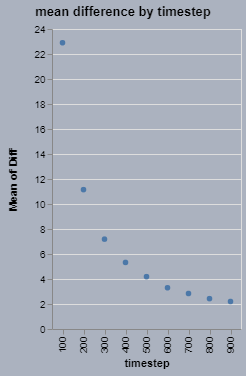

mean percent difference:


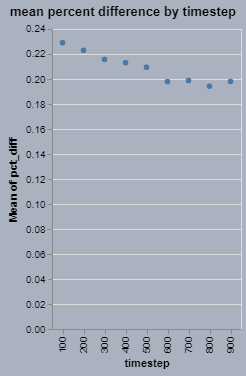

In [8]:
OP.plot_mean_differences()

## sim vs real comparison

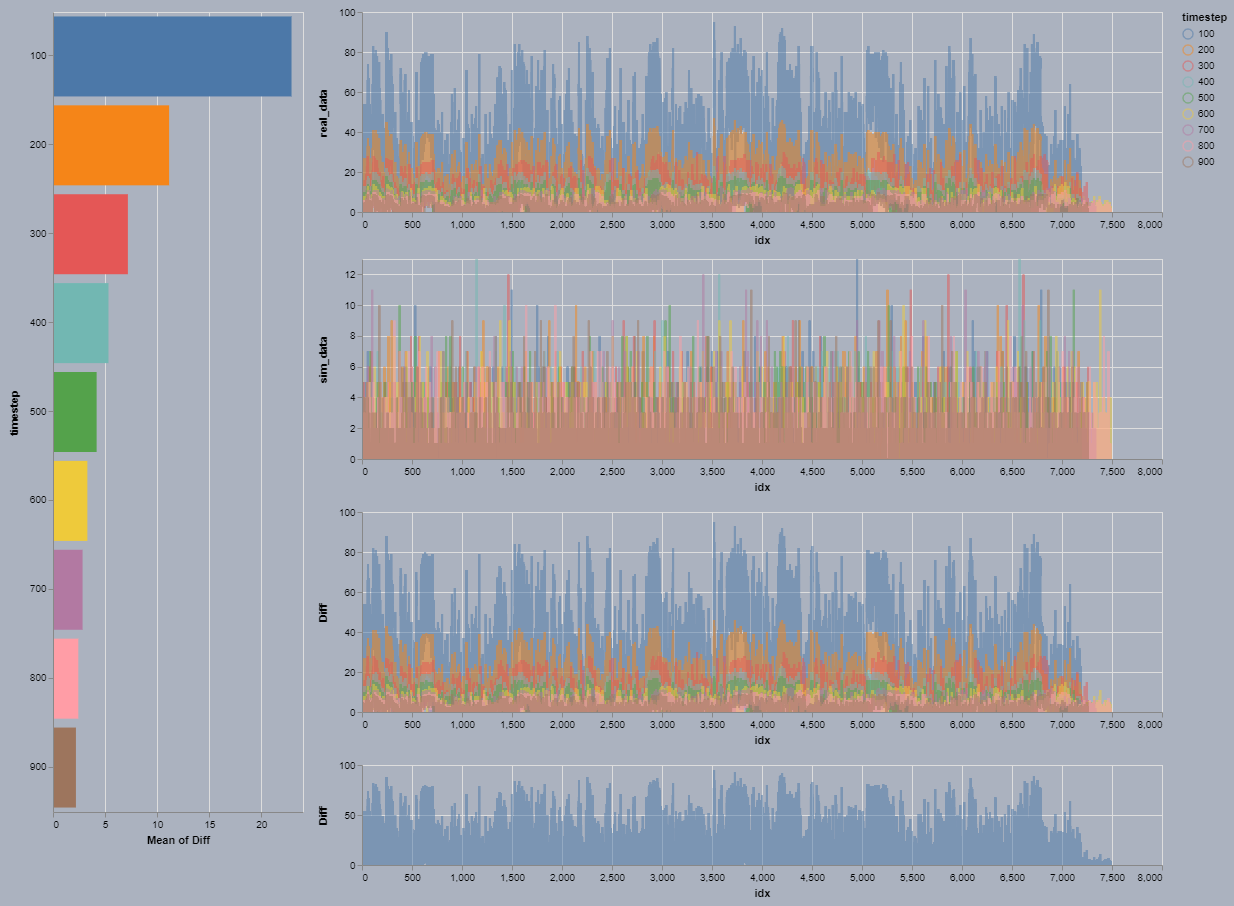

In [14]:
# force to disk
OP.full_comp_df.reset_index().rename({'index':'idx'}, axis=1).to_csv('data/full_comp_for_chart.csv', index=True)

# set data ref
alt_url = 'data/full_comp_for_chart.csv'



#----------------------- bar chart -----------------------
sel_iter_var = alt.selection_single(encodings=['y'])

bar_chart = alt.Chart(
    alt_url,
    #.sample(frac=0.1),
    width=250,
    height=800
).mark_bar(
).encode(
    alt.X('mean(Diff):Q'),
    alt.Y(f'{OP.iter_var}:N'),
    color=alt.condition(
        sel_iter_var,
        f'{OP.iter_var}:N',
        alt.value('#96989b'),
        legend=None
    )
).add_selection(
    sel_iter_var
)
#.configure(background='#abb2bf')


#----------------------- signals -----------------------

x_scaler = alt.selection_interval(encodings=['x'])

base = alt.Chart(
    alt_url,
    #OP.full_comp_df.reset_index().sample(frac=0.5),
    height=200,
    width=800
).transform_filter(
    sel_iter_var
).mark_line(
    opacity=0.5
).encode(
    alt.X('idx:Q', scale={'domain': x_scaler.ref()}),
    #alt.Y('real_data:Q')
)

layered = alt.vconcat(
    base.encode(
        alt.Y('real_data:Q'),
        #color=alt.value('#4286f4') # blue
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('sim_data:Q'),
        #color=alt.value('#41f470') # green
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
    base.encode(
        alt.Y('Diff:Q'),
        #color=alt.value('#f44141') # red
        color=f'{OP.iter_var}:N'
    ).transform_filter(x_scaler),
)

wide = base.encode(alt.Y('Diff:Q')).add_selection(x_scaler).properties(height=100)

signal_concat = alt.vconcat(
    layered, 
    wide
)

alt.hconcat(
    bar_chart,
    signal_concat,
    background='#abb2bf'
)



## misfits